2024/06/07
__________
1:53am : I've figure out how to get a preloaded ds from torch.vision. Next I want to do is to resize all the tensors in my dataset at once.

10:13am: Arrived. I should look at how to perform TSNE first, then how to make a custom dataset and see if they overlap. I got this.

10:25am: Okay able to resize images i think. Next up is simple TSNE on it.

11:05am: Okay some sort of visualization has been achieved. Using toTensor() to numericalize images. Now we want to use embeddings of a model to see if the clusters are any more emminent, and they should be.

11:33am I guess this is done? Now will go back and try to visualize it in 3d with photo popup when clicked ?

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets,  transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [8]:
# Setup training data

data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(28,28)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform= data_transform, # images come as PIL format, we want to turn into Torch tensors

)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=data_transform
)

AttributeError: 'FashionMNIST' object has no attribute 'dtype'

In [14]:
''' use subset to create a sample dataset '''


from torch.utils.data import DataLoader, Subset
subset_indices = list(range(500))
train_subset = Subset(train_data, subset_indices)


In [17]:
len(train_subset)

500

In [38]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
train_subset_dataloader = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True)

In [39]:
''' so you use dataloader to create an iterable over the dataset wow'''

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

train_subset_features, train_subset_labels=next(iter(train_subset_dataloader))
print(f"Feature batch shape: {train_subset_features.size()}")


Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])
Feature batch shape: torch.Size([500, 1, 28, 28])


32

In [40]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


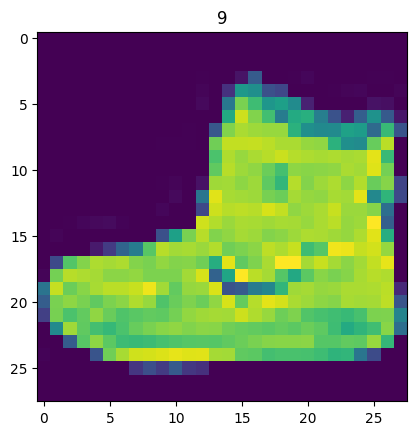

In [16]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

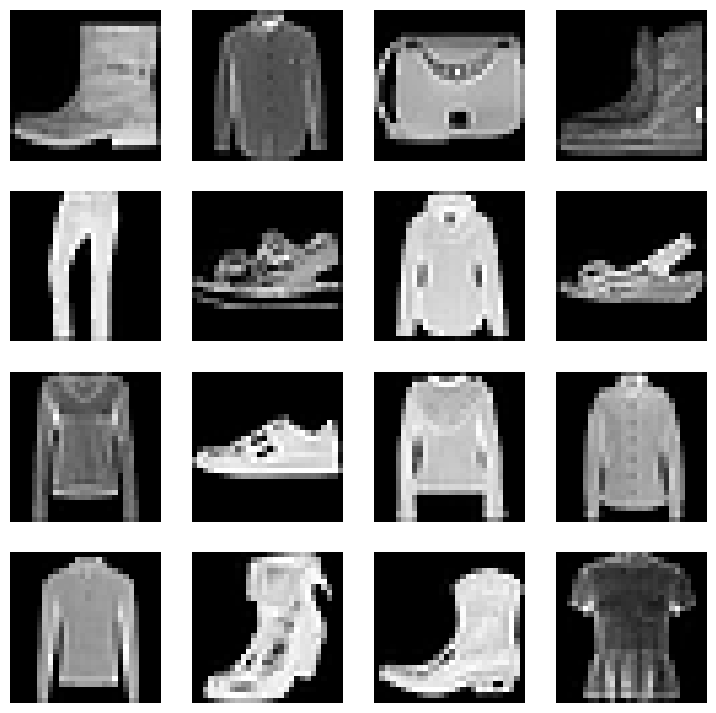

In [18]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")

    plt.axis(False);

In [20]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [40]:
''' how to resize a batch of images'''

images_flattened_subset = train_subset_features.view(train_subset_features.size(0), -1)
print(f"Flattened shape: {images_flattened_subset.shape}")



Flattened shape: torch.Size([500, 784])


In [42]:
'''Performs TSNE and plots it'''

from sklearn.manifold import TSNE
import plotly.express as px
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(images_flattened_subset)
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=train_subset_labels)
fig.update_layout(
    title="t-SNE visualization of dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['scatter', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy



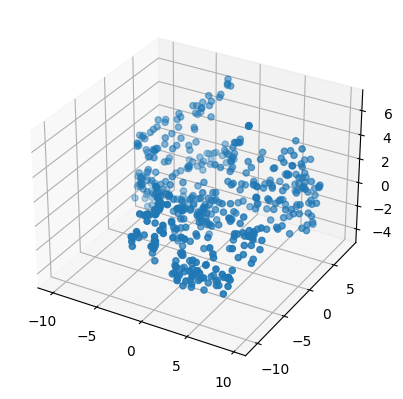

In [46]:
from matplotlib import pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
%matplotlib inline
%pylab inline
data = TSNE(n_components=3, random_state=0).fit_transform(images_flattened_subset )
x, y, z = list(zip(*data))

fig = pylab.figure()
ax = fig.add_subplot(111, projection = '3d')
sc = ax.scatter(x,y,z)

In [48]:
''' Using any cnn model for embds by removing the output layer '''
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
layer = model._modules.get('avgpool')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [53]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Function to capture the embeddings from the penultimate layer
outputs = []
def copy_embeddings(m, i, o):
    o = o.detach().cpu().numpy().tolist()
    outputs.append(o)

# Attach the hook to the penultimate layer (before the final fully connected layer)
model.avgpool.register_forward_hook(copy_embeddings)

# Set the model to evaluation mode
model.eval()

# Generate image embeddings for all images in the dataset and save them in the list 'outputs'
for images, labels in train_subset_dataloader:
    _ = model(images)

# Flatten list of embeddings to remove batches
list_embeddings = [item for sublist in outputs for item in sublist]

# Print the length of embeddings and shape of the first embedding
print(len(list_embeddings))  # Should return the total number of images
print(np.array(list_embeddings[0]).shape)  # Shape should correspond to the penultimate layer's output size




500
(512, 1, 1)


(500, 512)


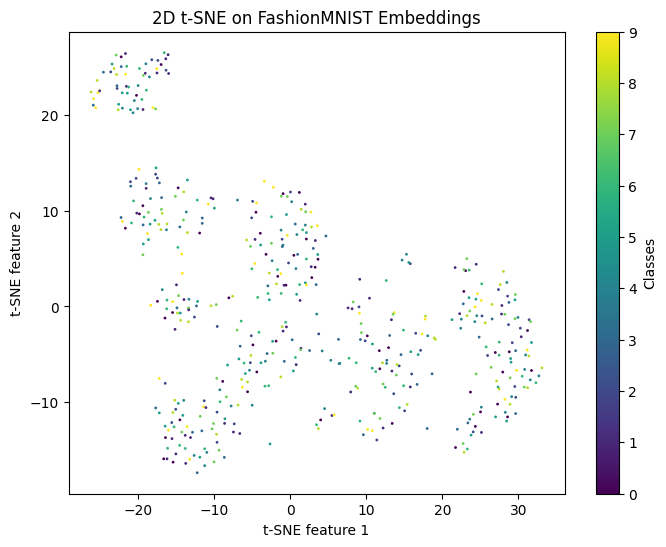

In [65]:
tsne = TSNE(n_components=3, random_state=0)
embeddings_array = np.array(list_embeddings)

new_shape = (len(train_subset), 512)
embeddings_array = np.reshape(embeddings_array , new_shape)
print(embeddings_array.shape)

embeddings_tsne = tsne.fit_transform(embeddings_array)




tsne_2d = TSNE(n_components=2, random_state=0)
embeddings_tsne_2d = tsne_2d.fit_transform(embeddings_array)

# Visualize t-SNE result in 2D
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne_2d[:, 0], embeddings_tsne_2d[:, 1], c=[label for _, label in train_subset], cmap='viridis', s=1)
plt.title('2D t-SNE on FashionMNIST Embeddings')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar(label='Classes')
plt.show()

In [ ]:

# Visualize t-SNE result in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], embeddings_tsne[:, 2], c=[label for _, label in train_subset], cmap='viridis', s=1)

# Add legend and color bar
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
cb = plt.colorbar(scatter)
cb.set_label('Classes')

# Set labels and title
ax.set_title('3D t-SNE on FashionMNIST Embeddings')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')

plt.show()

In [ ]:
''' going back to robo whatever video'''

